##Transfer Learning with TF Part 2 Fine Tuning 

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
#creating Helper functions

!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

--2023-05-29 17:03:59--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘helper_functions.py.2’

helper_functions.py     [ <=>                ] 263.34K  --.-KB/s    in 0.1s    

2023-05-29 17:03:59 (2.06 MB/s) - ‘helper_functions.py.2’ saved [269660]



In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [2]:
#get 10% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip



--2023-05-30 03:28:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.1MB/s    in 6.8s    

2023-05-30 03:28:21 (23.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
unzip_data("10_food_classes_10_percent.zip")

In [4]:
walk_through_dir("10_food_classes")

In [11]:
# create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [12]:
from numpy.random import test
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

In [ ]:
#Creating TF keras functional API
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#if using ResNet50 V2 normalise the inputs
#x = tf.keras.layers.experimental.prerocessing.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"shape after passing inputs through base model:{x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling2D")(x)
print(f"Shape after Global_avg_pooling2D:{x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax",name="output_layers")(x)

model_0 = tf.keras.Model(inputs,outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

his_0 = model_0.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks=create_tensorboard_callback("Transfer_learning",
                                                          "10_percent_feature_extraction"))

shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after Global_avg_pooling2D:(None, 1280)
Saving TensorBoard log files to: Transfer_learning/10_percent_feature_extraction/20230529-170412
Epoch 1/5
24/24 [==============================] - 116s 4s/step - loss: 1.8166 - accuracy: 0.4600 - val_loss: 1.2647 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 136s 6s/step - loss: 1.0605 - accuracy: 0.7987 - val_loss: 0.8791 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 90s 4s/step - loss: 0.7758 - accuracy: 0.8227 - val_loss: 0.7032 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 91s 4s/step - loss: 0.6329 - accuracy: 0.8547 - val_loss: 0.6117 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 90s 4s/step - loss: 0.5447 - accuracy: 0.8787 - val_loss: 0.5611 - val_accuracy: 0.8618


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 165s 2s/step - loss: 0.5564 - accuracy: 0.8588


[0.5564417243003845, 0.8587999939918518]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
base_model.summary()

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling2D (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


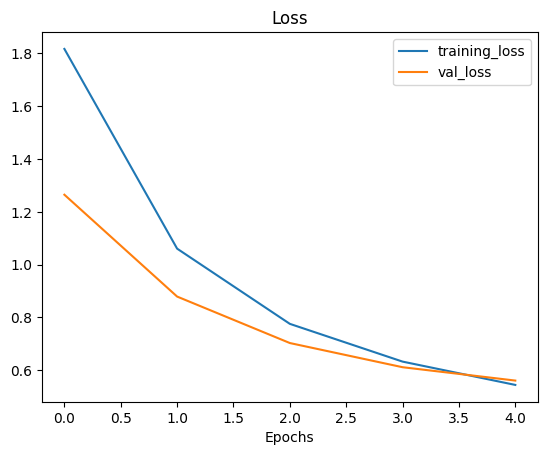

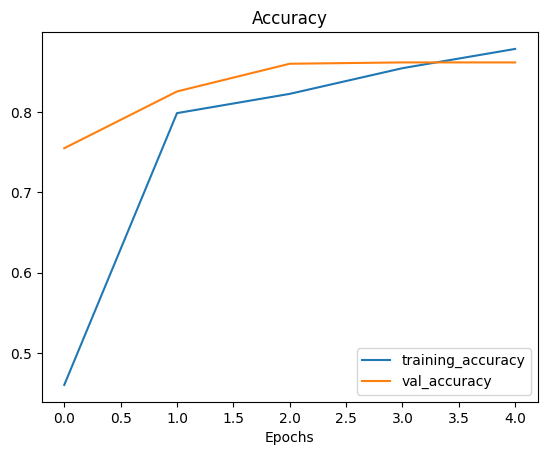

In [ ]:
plot_loss_curves(his_0)

In [ ]:
#getting a feature vector from our trained model

input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"{input_tensor}\n")

x = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"global_avg_pooled {x}\n")

print(f"shape of input {input_tensor.shape}")
print(f"global_avg_pooling shape {x.shape}")

[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

global_avg_pooled [[-0.09368646 -0.45840445 -0.28855976]]

shape of input (1, 4, 4, 3)
global_avg_pooling shape (1, 3)


In [ ]:
#let's replicate global avg pooling 2D

tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [ ]:
max =tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"{max}\n")

[[0.9058464 1.1603122 1.6994323]]



In [16]:
# Creating model_1 (1% of data)

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-05-30 03:31:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  25.0MB/s    in 6.2s    

2023-05-30 03:31:25 (20.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [17]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [18]:
#Getting and preprocessing data for model_1

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.


# adding data Augmentation right into our model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2,),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")


(-0.5, 565.5, 334.5, -0.5)

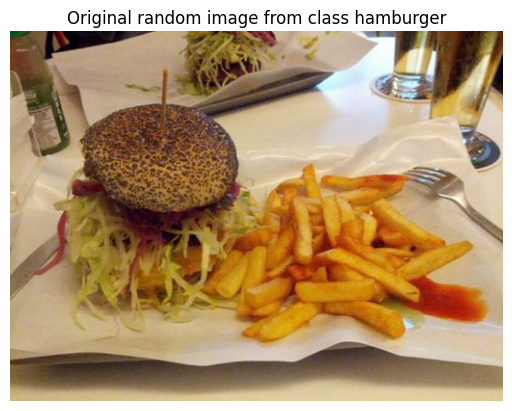

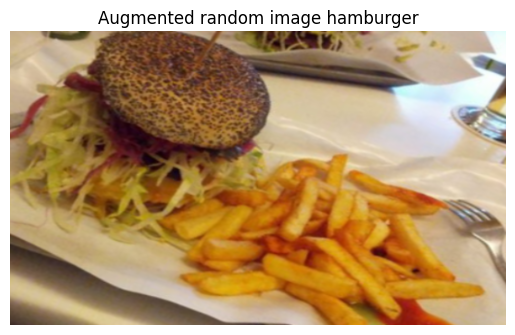

In [19]:
#viz our data augmentation

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir +"/"+random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image {target_class}")
plt.axis(False)

#Model 1 with Data augmentation and 1% of data

In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_shape")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

his_1 = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data =test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks = create_tensorboard_callback("Transfer_learning","1_Percent_data_aug"))

Saving TensorBoard log files to: Transfer_learning/1_Percent_data_aug/20230529-171850
Epoch 1/5
3/3 [==============================] - 55s 22s/step - loss: 2.3298 - accuracy: 0.1143 - val_loss: 2.2282 - val_accuracy: 0.1891
Epoch 2/5
3/3 [==============================] - 46s 22s/step - loss: 2.0592 - accuracy: 0.3571 - val_loss: 2.1016 - val_accuracy: 0.2533
Epoch 3/5
3/3 [==============================] - 46s 22s/step - loss: 1.8685 - accuracy: 0.4286 - val_loss: 1.9905 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 47s 22s/step - loss: 1.7213 - accuracy: 0.5571 - val_loss: 1.8756 - val_accuracy: 0.3849
Epoch 5/5
3/3 [==============================] - 88s 42s/step - loss: 1.5561 - accuracy: 0.6714 - val_loss: 1.7751 - val_accuracy: 0.4539


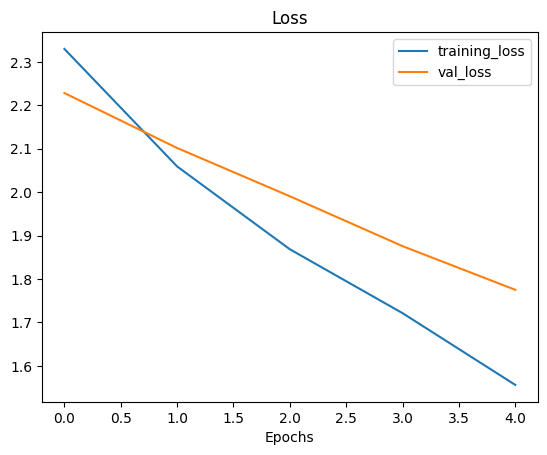

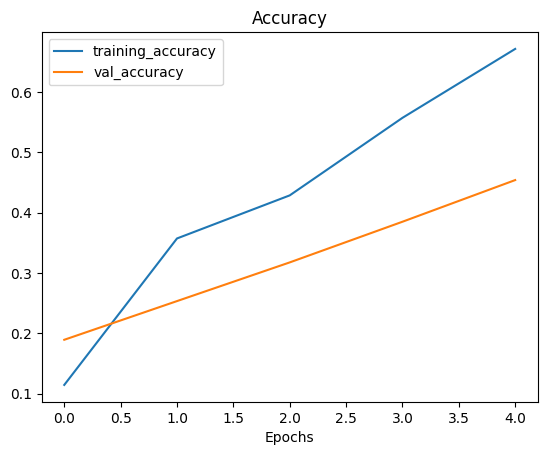

In [ ]:
plot_loss_curves(his_1)

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 186s 2s/step - loss: 1.7692 - accuracy: 0.4552


[1.769159197807312, 0.4551999866962433]

In [5]:
#building model 2 with data aug and 10% training data
train_dir_10_percent = "10_food_classes_!0_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [20]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
])

input_shape = (224,224,3)

base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

inputs=layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")


16705208/16705208 [==============================] - 1s 0us/step


In [21]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
______________________________________________

#creating a Model Checkpoint callback

In [22]:
#set checkpoint path
checkpoint_path = "10%_model_checkpoint_weights/checkpoint.ckpt"

#create a Modelcheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)


In [24]:
his_2 = model_2.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks=[create_tensorboard_callback("Transfer_learning","10_percent_data_aug"),
                               checkpoint_callback])

Saving TensorBoard log files to: Transfer_learning/10_percent_data_aug/20230530-033536
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.3098 - accuracy: 0.7120
Epoch 1: saving model to 10%_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 145s 6s/step - loss: 1.3098 - accuracy: 0.7120 - val_loss: 0.9848 - val_accuracy: 0.7780
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.9907 - accuracy: 0.7720
Epoch 2: saving model to 10%_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 142s 6s/step - loss: 0.9907 - accuracy: 0.7720 - val_loss: 0.7792 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.8339 - accuracy: 0.7960
Epoch 3: saving model to 10%_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 141s 6s/step - loss: 0.8339 - accuracy: 0.7960 - val_loss: 0.6882 - val_accuracy: 0.8339
Epoch 4/5
24/24 [=================

In [25]:
model_0.evaluate(test_data),model_2.evaluate(test_data)

NameError: ignored

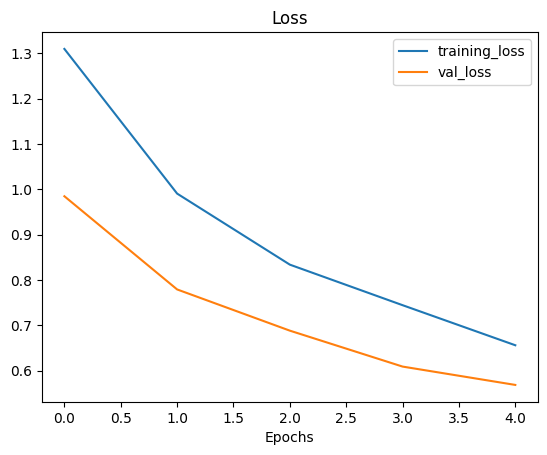

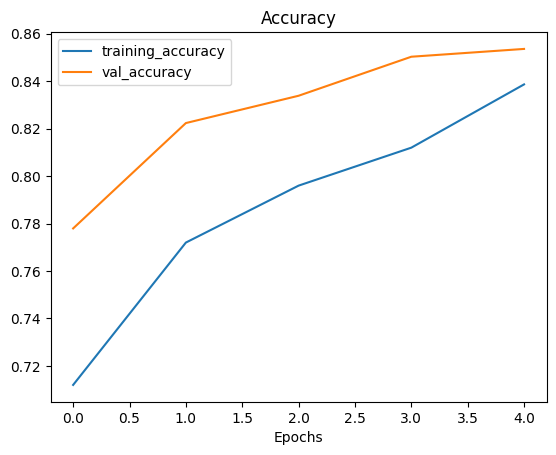

In [26]:
plot_loss_curves(his_2)

In [27]:
results_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 275s 3s/step - loss: 0.5892 - accuracy: 0.8436


In [28]:
#loading in Checkpoint weights
model_2.load_weights(checkpoint_path)

In [29]:
loaded_weights = model_2.evaluate(test_data)

79/79 [==============================] - 288s 4s/step - loss: 0.5892 - accuracy: 0.8436


In [30]:
loaded_weights == results_10_percent

False

In [31]:
import numpy as np
np.isclose(np.array(results_10_percent), np.array(loaded_weights))

array([ True,  True])

#model 3 Fine tuning model

fine tunning model works best after feature extraction model

In [32]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc494649720> True
<keras.engine.sequential.Sequential object at 0x7fc49471aa40> True
<keras.engine.functional.Functional object at 0x7fc4940f92d0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fc4940e5d50> True
<keras.layers.core.dense.Dense object at 0x7fc494627f70> True


In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [34]:
print(len(model_2.layers[2].trainable_variables))

0


In [35]:
#let's set last 10 layers to true
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

In [36]:
#recompile (we have to recompile our models every time we make a change)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics="accuracy")


In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [38]:
print(len(model_2.trainable_variables))

12


In [39]:
#fine tune for another 5 epochs
fine_tune_epochs = 10

#refit the model
his_3 = model_2.fit(train_data_10_percent,
                    epochs=fine_tune_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    initial_epoch=his_2.epoch[-1],
                    callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                                           experiment_name= "10%_fine_tuning_last_10")])

Saving TensorBoard log files to: Transfer_learning/10%_fine_tuning_last_10/20230530-040115
Epoch 5/10
24/24 [==============================] - 162s 6s/step - loss: 0.5774 - accuracy: 0.8480 - val_loss: 0.4364 - val_accuracy: 0.8668
Epoch 6/10
24/24 [==============================] - 154s 7s/step - loss: 0.4366 - accuracy: 0.8867 - val_loss: 0.4081 - val_accuracy: 0.8635
Epoch 7/10
24/24 [==============================] - 113s 5s/step - loss: 0.4065 - accuracy: 0.8920 - val_loss: 0.4171 - val_accuracy: 0.8602
Epoch 8/10
24/24 [==============================] - 151s 6s/step - loss: 0.3773 - accuracy: 0.8907 - val_loss: 0.3782 - val_accuracy: 0.8717
Epoch 9/10
24/24 [==============================] - 114s 5s/step - loss: 0.3356 - accuracy: 0.9080 - val_loss: 0.3562 - val_accuracy: 0.8832
Epoch 10/10
24/24 [==============================] - 146s 6s/step - loss: 0.3040 - accuracy: 0.9040 - val_loss: 0.3969 - val_accuracy: 0.8586


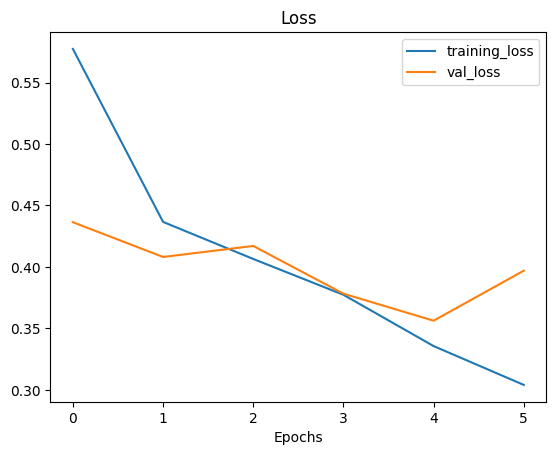

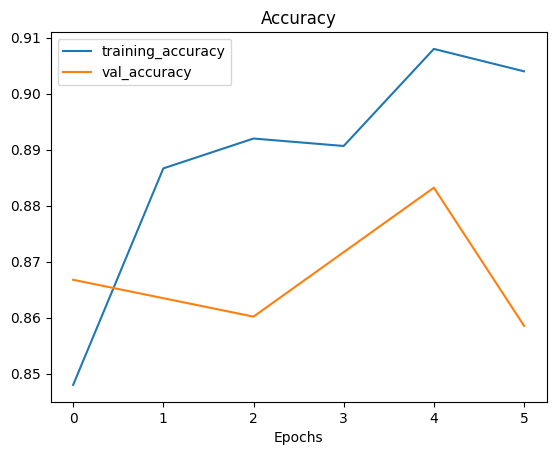

In [40]:
plot_loss_curves(his_3)

In [50]:
#let's create a function to compare training histories
def compare_histories(original_history,new_history, initial_epochs=5):
  """Compares two TF History objects"""
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val accuracy")
  plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(), label="start Fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(), label="start Fine tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")

In [46]:
initial_epoch=5

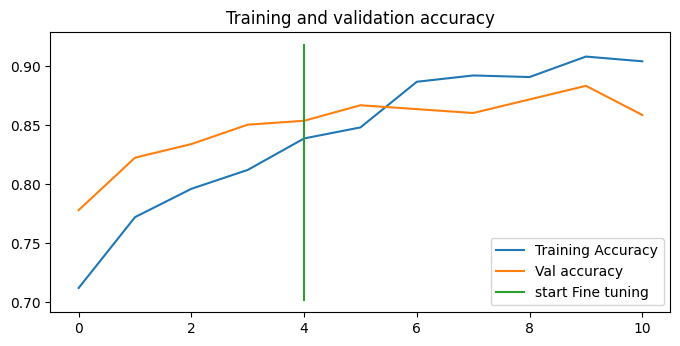

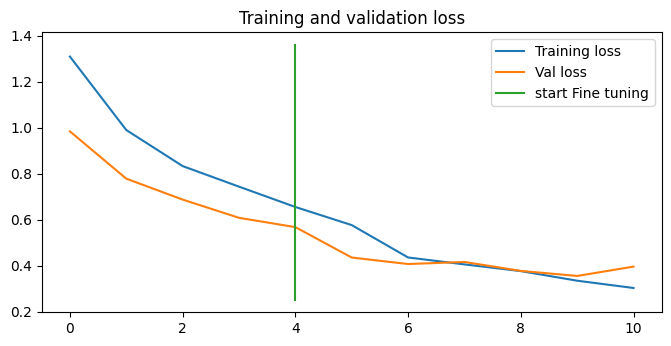

In [51]:
compare_histories(his_2,his_3,initial_epochs=5)

# Preparing data for model_4


In [52]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-05-30 04:23:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  31.0MB/s    in 17s     

2023-05-30 04:23:31 (29.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [53]:
train_dir_all = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [55]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [57]:
IMG_SIZE =(224,224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")

Found 7500 files belonging to 10 classes.


#to train a fine-tuning model we need to revert model_2 back to it's feature extraction weights.

In [58]:
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [59]:
base_model.trainable = False
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
model_2.load_weights(checkpoint_path)

In [61]:
model_2.evaluate(test_data)

79/79 [==============================] - 211s 3s/step - loss: 0.5892 - accuracy: 0.8436


[0.5892444849014282, 0.8435999751091003]

In [62]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_2 True
1 sequential True
2 efficientnetb0 False
3 global_average_pooling2d True
4 dense True


In [65]:
#let's set last 10 layers to true
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

In [66]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [67]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics="accuracy")

In [70]:
final_epochs = initial_epoch +5
his_4 = model_2.fit(train_data_10_classes_full,
                    epochs=final_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    initial_epoch=his_2.epoch[-1],
                    callbacks=[create_tensorboard_callback(dir_name="Trai=nsfer Learning",
                                                          experiment_name="Full_10_classes_fine_tuning")])

Saving TensorBoard log files to: Trai=nsfer Learning/Full_10_classes_fine_tuning/20230530-044536
Epoch 5/10
235/235 [==============================] - 762s 3s/step - loss: 0.6461 - accuracy: 0.7951 - val_loss: 0.3439 - val_accuracy: 0.8997
Epoch 6/10
235/235 [==============================] - 706s 3s/step - loss: 0.5222 - accuracy: 0.8349 - val_loss: 0.2834 - val_accuracy: 0.9046
Epoch 7/10
235/235 [==============================] - 730s 3s/step - loss: 0.4738 - accuracy: 0.8451 - val_loss: 0.2845 - val_accuracy: 0.9046
Epoch 8/10
235/235 [==============================] - 734s 3s/step - loss: 0.4261 - accuracy: 0.8605 - val_loss: 0.2507 - val_accuracy: 0.9194
Epoch 9/10
235/235 [==============================] - 741s 3s/step - loss: 0.3844 - accuracy: 0.8769 - val_loss: 0.2632 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 675s 3s/step - loss: 0.3560 - accuracy: 0.8839 - val_loss: 0.2565 - val_accuracy: 0.9161


In [71]:
results_fine_tuning_full_data = model_2.evaluate(test_data)
results_fine_tuning_full_data

79/79 [==============================] - 189s 2s/step - loss: 0.2738 - accuracy: 0.9144


[0.273796021938324, 0.9143999814987183]

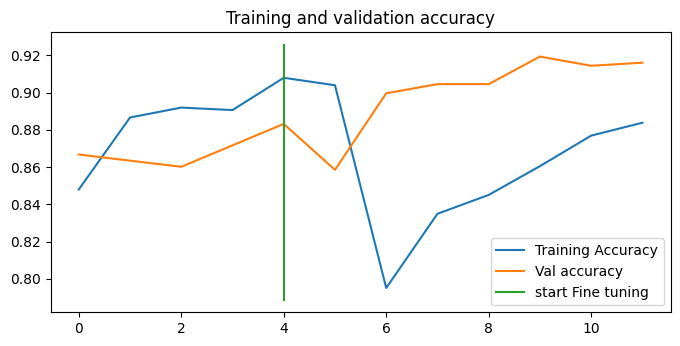

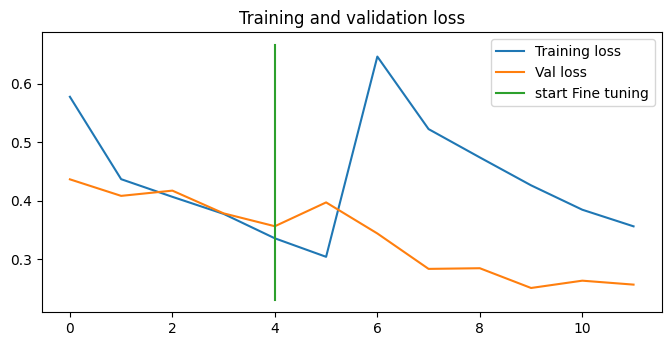

In [72]:
compare_histories(his_3, his_4, initial_epochs=5)

In [78]:
#vewing our exp on tensorboard
!tensorboard dev upload --logdir ./Transfer_learning \
  --name "Transfer Learning Exp with 10 Food 101 classes" \
  --description "A series of diff TL exp with varying amounts of data and fine tuning" \
  --one_shot

2023-05-30 06:17:24.820844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/qpsXWm5oTZmy2RxqkXS0tg/

[2023-05-30T06:17:27] Started scanning logdir.
[2023-05-30T06:17:34] Total uploaded: 104 scalars, 0 tensors, 4 binary objects (3.4 MB)
[2023-05-30T06:17:34] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/qpsXWm5oTZmy2RxqkXS0tg/


In [77]:
#Done. View your TensorBoard at https://tensorboard.dev/experiment/w2QMhNZVT1mvz92uefLGAg/